# Recommendations with IBM


By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>

Let's get started by importing the necessary libraries and reading in the data.

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [51]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>


`1.` What is the distribution of how many articles a user interacts with in the dataset?   

In [52]:
count_articles = df.groupby('email').count()['article_id'].sort_values(ascending=False)

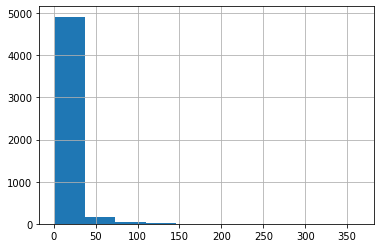

In [53]:
count_articles.hist()

In [54]:
np.median(count_articles.values)

3.0

In [55]:
np.max(count_articles.values)

364

In [56]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3
max_views_by_user = 364

`2.` Exploring and removing duplicate articles from the **df_content** dataframe.  

In [57]:
# Find and explore duplicate articles
df_content.duplicated(subset='article_id').sum()

5

In [58]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset='article_id', keep='first')

`3.` In the cells below, we will find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [11]:
df.article_id.nunique()

714

In [12]:
df_content.article_id.nunique()

1051

In [13]:
df.email.nunique()

5148

In [14]:
df.shape[0]

45993

In [15]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Now we will find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [59]:
df.groupby('article_id').count()['email'].sort_values(ascending=False).reset_index().iloc[0,]

article_id    1429.0
email          937.0
Name: 0, dtype: float64

In [60]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [61]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [62]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Here, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` The function below will return the **n** top articles ordered with most interactions as the top. We will also test our functions.

In [63]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df.groupby('article_id').count()['user_id'].sort_values(ascending=False).reset_index()['article_id'].values[:n]
    top_articles = df[df['article_id'].isin(top_articles)]['title'].unique()
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df.groupby('article_id').count()['user_id'].sort_values(ascending=False).reset_index()['article_id'].values[:n]
    top_articles = df[df['article_id'].isin(top_articles)]['article_id'].unique()
    return top_articles
 
    return top_articles # Return the top article ids

In [64]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo'
 'use deep learning for image classification'
 'apache spark lab, part 1: basic concepts'
 'predicting churn with the spss random tree algorithm'
 'analyze energy consumption in buildings'
 'visualize car data with brunel'
 'use xgboost, scikit-learn & ibm watson machine learning apis'
 'gosales transactions for logistic regression model'
 'insights from new york car accident reports'
 'finding optimal locations of new store using decision optimization']
[1314. 1429. 1170. 1364. 1162. 1431. 1427. 1304. 1330. 1293.]


In [65]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` The function below will be used to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then we will place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then we will place a zero where the user-row meets for that article-column**. 

We will use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [66]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.groupby(['user_id', 'article_id'])['user_id'].nunique().unstack().fillna(0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [68]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed the quick tests!  Please proceed!")

You have passed the quick tests!  Please proceed!


`2.` The function below will take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result will not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

We will use the tests to test your function.

In [69]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    no_of_users = user_item.shape[0]
    provided_user = user_item.loc[user_id].values
    
    similar_users = {}
    for i in range(1, no_of_users + 1):
        other_user = user_item.loc[i].values
        dist = np.dot(provided_user, other_user)
        similar_users[i] = dist

    # sort by similarity
    sorted_dict = sorted(similar_users.items(), key=lambda x: x[1], reverse=True)
    
    most_similar_users = list(map(lambda x: x[0], sorted_dict))
    
    # remove the own user's id
    most_similar_users.remove(user_id)   
    return most_similar_users # return a list of the users in order from most to least similar
        

In [70]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [71]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = list(df[df['article_id'].isin(article_ids)]['title'].unique().astype(str))
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = list(user_item.loc[user_id][user_item.loc[user_id] == 1].index.astype(str))
    
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    similar_users = find_similar_users(user_id)
    recs = []
    articles_seen_ids, articles_seen_names = get_user_articles(user_id)
    for user in similar_users:
        articles_seen_ids_other, articles_seen_names_other = get_user_articles(user)

        new_recs = np.setdiff1d(articles_seen_ids_other, articles_seen_ids, assume_unique=True)
        
        # Update recs with new recs
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))
        
        # If we have enough recommendations exit the loop
        if len(recs) > m-1:
            recs = recs[:m]
            break
    return recs # return your recommendations for this user_id    

In [72]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['analyze energy consumption in buildings',
 'analyze accident reports on amazon emr spark',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'airbnb data for analytics: vancouver listings',
 'recommender systems: approaches & algorithms',
 'airbnb data for analytics: mallorca reviews',
 'analyze facebook data using ibm watson and watson studio',
 'a tensorflow regression model to predict house values']

In [73]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - we will choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, we will choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [74]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    #get df of similar users and df of user-article interactions
    similar_users = user_item.dot(user_item[user_item.index == 1].T)
    
    #sort user and remove most similar user because it will be the same as input user_id
    similar_users = similar_users.sort_values(similar_users.columns[0], ascending=False)[1:]
    user_interactions  = df.groupby('user_id', sort=False).count()
    
    # merge similar users and user-interactions df's and format them for easy use
    neighbors_df = pd.merge(similar_users, user_interactions, how='left', left_index=True, right_index=True)
    neighbors_df = neighbors_df.drop('title', axis=1).reset_index()
    neighbors_df.columns = ['neighbor_id', 'similarity','interactions']
    neighbors_df = neighbors_df.sort_values(['similarity','interactions'],ascending=False).reset_index()
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    recs = []
    neighbors_df = get_top_sorted_users(user_id)
    neighbor_user_ids = neighbors_df['neighbor_id'].values
    articles_seen_ids, articles_seen_names = get_user_articles(user_id)
    
    for neighbor_id in neighbor_user_ids:
        articles_seen_ids_other, articles_seen_names_other = get_user_articles(neighbor_id)
        
        articles_interactions_tuple = list(map(lambda x: (x, user_item[float(x)].sum()), articles_seen_ids_other))        
        
        articles_interactions_tuple = sorted(articles_interactions_tuple, key=lambda x: x[1], reverse=True)
        
        neighbor_articles = list(map(lambda x: x[1], articles_interactions_tuple))
        
        new_recs = np.setdiff1d(articles_seen_ids_other, articles_seen_ids, assume_unique=True)
        
        # Update recs with new recs
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))
        
        # If we have enough recommendations exit the loop
        if len(recs) > m-1:
            recs = recs[:m]
            break
    # Your code here
    rec_names = get_article_names(recs)
    return recs, rec_names

In [75]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1052.0' '109.0' '1170.0' '1183.0' '1185.0' '1232.0' '1293.0' '1305.0'
 '1363.0' '1368.0']

The top 10 recommendations for user 20 are the following article names:
['classify tumors with machine learning', 'apache spark lab, part 1: basic concepts', 'access db2 warehouse on cloud and db2 with python', 'putting a human face on machine learning', 'gosales transactions for naive bayes model', 'finding optimal locations of new store using decision optimization', 'tensorflow quick tips', 'country statistics: life expectancy at birth', 'categorize urban density', 'predict loan applicant behavior with tensorflow neural networking']


`5.` We will use our functions from above to correctly fill in the solutions to the dictionary below.  Then test our dictionary against the solution.  

In [76]:
### Tests with a dictionary of results

user1_most_sim = find_similar_users(1)[0]# Find the user that is most similar to user 1 
user131_10th_sim = find_similar_users(131)[9]# Find the 10th most similar user to user 131

In [77]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would we be able to use to make recommendations?  Explain.  Can we think of a better way we might make recommendations?  

***Given a new user, we can use our rank based method defined above as function to make recommendations. In case of a new article, a much better way to do this is by using a content based recommendation system to recommend the article to appropriate users***

`7.` Using our existing functions, we will now provide the top 10 recommended articles we would provide for the a new user below.  We can test our function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [78]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10).astype(str)# Your recommendations here


In [79]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, we will use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` This first question here will just require that we run the cells to get things set up for the rest of **Part V** of the notebook. 

In [82]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

`2.` In this situation, we can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  We will ise the cell to perform SVD.

In [83]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

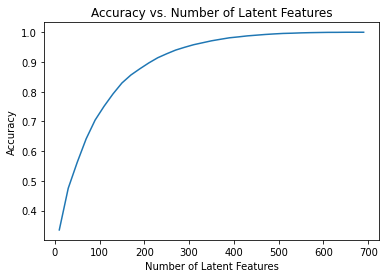

In [84]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

We will use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [1]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = np.array(user_item_test.index.unique())
    test_arts = np.array(user_item_test.columns.unique())
    # Your code here
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

NameError: name 'df' is not defined

In [86]:
user_item_test.shape

(682, 574)

In [87]:
len(test_idx) - len(set(user_item_test.index.unique()) - set(user_item_train.index.unique()))

20

In [88]:
len(set(user_item_test.index.unique()) - set(user_item_train.index.unique()))

662

In [89]:
len(set(user_item_test.columns.unique()) - set(user_item_train.columns.unique()))

0

In [90]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d# letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now we will use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that we can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

We will use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [91]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below

In [92]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

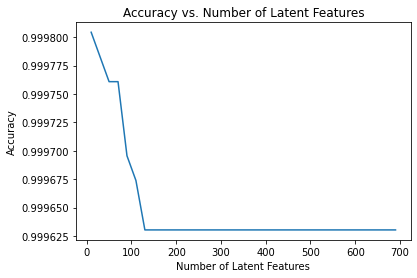

In [93]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    err = []
    for idx in range(len(test_idx)):
        try:
            user_id = test_idx[idx]
            article_id = test_arts[idx]
            user_ids_series = np.array(user_item_test.index)
            movie_ids_series = np.array(user_item_test.columns)

        # User row and Movie Column
            user_row = np.where(user_ids_series == user_id)[0][0]
            movie_col = np.where(movie_ids_series == article_id)[0][0]


            user_item_est = np.around(np.dot(np.dot(u_new[user_row, :], s_new), vt_new[:, movie_col]))
            err.append(np.subtract(user_item_test.iloc[user_row, movie_col], user_item_est))
        except:
            continue
    # take dot product
#    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
#    diffs = np.subtract(user_item_train, user_item_est)
    
    # total errors and keep track of them
#    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(np.sum(np.abs(err)))
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` We will now comment on the results we found in the previous question. Given the circumstances of our results, discuss what we might do to determine if the recommendations we make with any of the above recommendation systems are an improvement to how users currently find articles? 

**If we see the results of our recommendation system on test set, as we increase the number of latent features the accuracy seems to go down and the best accuracy is found when latent features are equal to 10.**

**Although the accuracy seems to be pretty good, accuracy here is not a good measure to show to effectiveness of our model as it just predicts the values in the user_item matrix which is a sparse matrix having a lot of 0 values making it easy for prediction**

**One way to determine this can be by using A/B testing, we can divide our audience into experiment and control groups and see if deploying this recommendation system increases user interactions while keeping other factors the same**